# MCMC y diagnóstico del muestro

In [1]:
import arviz as az
import pymc as pm
import preliz as pz
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact
import ipywidgets as ipyw

In [2]:
az.style.use('arviz-doc')

## Objetivos

* Obtener nociones básicas de métodos de Markov Chain Monte Carlo y su rol en estadística Bayesiana

* Discutir algunos de los métodos de diagnóstico del muestreo más usados

El teorema de Bayes, tiene una formulación que a primera vista parece muy inocente. Tan solo cuatro términos relacionados por una multiplicación y una división.

$$
\underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}\; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{p(\boldsymbol{Y})}}_{\text{marginal likelihood}}}
$$

Pareciera que no sirve de mucho y que es fácil de calcular. Sin embargo, ambas apreciaciones son incorrectas. El resto de los capítulos se centran en mostrar contra ejemplos a la primera aseveración, asi que veamos por que a veces su cálculo puede ser dificil y se requieren métodos numéricos.

La razón está en el cálculo del likelihood marginal. El cual toma la forma de una integral.

$$
{p(\boldsymbol{Y}) = \int_{\boldsymbol{\Theta}} p(\boldsymbol{Y} \mid \boldsymbol{\theta})p(\boldsymbol{\theta}) d\boldsymbol{\theta}}
$$

Esta integral suele ser dificil de resolver. Veamos, esta expresión nos dice que debemos evaluar el likelihood para cada uno de los posibles valores del prior $\theta$. Estrictamente no podemos dejar ningún valor afuera, ni siquera focalizarnos en las combinaciones de prior y likelihood que resulten en valores de alta probabilidad para el likelihood (area gris en la siguiente figura). No, debemos evaluar todas y cada una de las posibilidades. Además si $\theta$ representa un solo parámetro desconocido (como en el modelo beta-binomial) entonces solo hay que resolver una integral, pero si $\theta$ representa dos parámetros (como en el modelo Gaussiano) entonces la integral será doble. En definitiva la integral tendrá tantas dimensiones como parámetros el modelo.

Para algunos pocos problemas es posible calcular el posterior de forma analítica. Esto ya lo vimos para el modelo beta-binomial donde el posterior es:


$$
p(\theta \mid y) \propto \operatorname{Beta}(\alpha_{a priori} + y, \beta_{a priori} + N - y)
$$


Pero en general no tenemos expresiones analíticas y entonces debemos confiar en métodos numéricos.

## Método de la grilla

El método de grilla es un enfoque simple de fuerza bruta. La idea central es que incluso si no somos
capaces de calcular todo la distribución a posteriori, en general si somos capaces de evaluar el
a priori y el likelihood punto-a-punto.

Para un modelo con un solo parámetro el método de la grilla se puede resumir de la siguiente forma:

* Encuentre un intervalo razonable para el parámetro (el prior debe dar algunas pistas).

* Defina una grilla de puntos (generalmente equidistantes) en ese intervalo.

* Para cada punto de la grilla, evalue el prior y el likelihood en ese punto y multiplique

In [3]:
def a_posteriori_grilla(grilla=10, a=1, b=1, caras=6, tiradas=9):
    grid = np.linspace(0, 1, grilla)
    prior = pz.Beta(a, b).rv_frozen.pdf(grid)
    likelihood = pz.Binomial(n=tiradas, p=grid).rv_frozen.pmf(caras)
    posterior = likelihood * prior
    posterior /= posterior.sum()
    _, ax = plt.subplots(1, 3, sharex=True, figsize=(16, 4))
    ax[0].set_title('caras = {}\ntiradas = {}'.format(caras, tiradas))
    for i, (e, e_n) in enumerate(zip([prior, likelihood, posterior], ['a priori', 'likelihood', 'a posteriori'])):
        ax[i].set_yticks([])
        ax[i].plot(grid, e, 'o-', label=e_n)
        ax[i].legend(fontsize=14)


interact(a_posteriori_grilla, grilla=ipyw.IntSlider(min=2, max=100, step=1, value=15), a=ipyw.FloatSlider(min=1, max=7, step=1, value=1), b=ipyw.FloatSlider(
    min=1, max=7, step=1, value=1), caras=ipyw.IntSlider(min=0, max=20, step=1, value=6), tiradas=ipyw.IntSlider(min=0, max=20, step=1, value=9));

interactive(children=(IntSlider(value=15, description='grilla', min=2), FloatSlider(value=1.0, description='a'…

Podemos obtener una mejor aproximación aumentando el número de puntos de la cuadrícula. Esta estrategia puede ser útil en unas pocas dimensiones (parámetros). Pero no escala. Supongamos que para el grado de precisión que necesitamos, 100 puntos fuesen suficiente. Para el mismo grado de precisión pero con 2 parámetros necesitariamos 10000 puntos y para 10 parámetros 1e+20 puntos! Además en espacios de alta dimensión se dan una serie de fenómemos conocidos como concentración de la medida o maldición de la dimensionalidad. Por ejemplo:

* En una hiper-esfera casi todo el volumen está en la superficie. Es decir, si uno pelara una hiper-naranja se quedaría casi sin naranja!

* En un hyper-cubo la masa se concentra en las esquinas
 
* En una Gaussiana hiper-dimensional casi toda la masa está lejos de la moda

La idea de evaluar punto a punto es buena, pero la idea de construir una grilla predefinida solo funciona en bajas dimensiones.

## Markov Chain Monte Carlo (MCMC)

Esta es una familia muy extensa de métodos utilizados para resolver muchos problemas, entre los que se encuentra el cálculo del posterior. Conceptualmente se puede pensar a estos métodos como generalizaciones del método de la grilla, ya que también se basan en la posibilidad de realizar evaluaciones punto a punto del prior y likelihood. La diferencia crucial es que en vez de utilizar una grilla predefinida el método realiza evaluaciones que progresivamente se concentran en regiones de alta probabilidad. No solo eso si no que eventualmente el método devolverá muestras de forma proporcional a la probabilidad a posteriori. Es decir si una región es 3 veces más probable que otra obtendremos 3 veces más muestras de esa región que de la otra.

A muy grandes razgos los métodos MCMC, constan de dos pasos

1. Generar un nuevo punto a partir de perturbar uno preexistente.
2. Aceptar o rechazar ese nuevo punto de forma probabilista y comparando la probabilidad del punto preexistente y del nuevo punto.



## Metropolis-Hastings

Metropolis-Hastings no es un algoritmo muy moderno o particularmente eficiente, pero Metropolis-Hastings es simple de entender y también proporciona una base para comprender métodos más sofisticados y poderosos. 

El algoritmo Metropolis-Hasting se define de la siguiente manera:

1. Inicialice el valor del parámetro $\boldsymbol{X}$ en $x_i$
2. Utilice una distribución de propuesta $q(x_{i + 1} \mid x_i)$ para generar un nuevo valor $x_{i + 1}$
3. Calcule la probabilidad de aceptar el nuevo valor como:

$$
p_a (x_{i + 1} \mid x_i) = \min \left (1, \frac{p(x_{i + 1}) \; 
q(x_i \mid x_{i + 1})} {p(x_i) \; q (x_{i + 1} \mid x_i)} \right)
\label{acceptance_prob}
$$

4. Si $p_a > R$ donde $R \sim \mathcal{U}(0, 1)$, guarde el nuevo valor; de lo contrario, guarde el anterior.
5. Iterar de 2 a 4 hasta que se haya generado una muestra de valores \textit{suficientemente grande}


El algoritmo Metropolis es muy general y se puede usar en aplicaciones no Bayesianas, pero para la presente discusión, $p(x_i)$ es la densidad del posterior evaluada en el valor del parámetro $x_i$. Observe que si $q$ es una distribución simétrica, los términos $q(x_i \mid x_{i + 1})$ y $q(x_{i + 1} \mid x_i)$ se cancelarán (conceptualmente significa que es igualmente probable que vayamos de $x_{i+1}$ a $x_i$ o de $x_{i}$ a $x_{i+1}$), dejando solo un cociente entre el psoterior evaluado en dos puntos. Este algoritmo siempre aceptará moverse de una región de baja probabilidad a una más alta y aceptará probabilísticamente moverse de una región de alta a una baja probabilidad.

¡Otra observación importante es que el algoritmo Metropolis-Hastings no es un método de optimización! No nos importa encontrar el valor del parámetro con la máxima probabilidad, queremos _explorar_ la distribución $p$. Es decir aún si el método encuentra un máximo aún puede moverse a regiones de probabilidades más bajas.

Para hacer las cosas más concretas, intentemos resolver el modelo Beta-Binomial. 

\begin{align}
\begin{split}
    \theta \sim &\; \text{Beta}(\alpha, \beta) \\
    Y \sim &\; \text{Bin}(n=1, p=\theta)
\label{eq:beta_binomial}
\end{split}
\end{align}

Este modelo tiene una solución analítica. Pero supongamos que no sabemos cómo calcular el posterior y, por lo tanto, implementaremos el algoritmo Metropolis-Hastings usando Python. 

In [4]:
def post(θ, Y, α=1, β=1):
    if 0 <= θ <= 1:
        prior = stats.beta(α, β).pdf(θ)
        like  = stats.bernoulli(θ).pmf(Y).prod()
        prob = like * prior
    else:
        prob = -np.inf
    return prob

También necesitamos datos, por lo que generaremos algunos datos falsos aleatorios para este propósito.

In [5]:
Y = stats.bernoulli(0.7).rvs(20)

Y finalmente ejecutamos nuestra implementación del algoritmo Metropolis-Hastings:

In [6]:
n_iters = 1000
can_sd = 0.05
α = β =  1
θ = 0.5 
trace = {"θ":np.zeros(n_iters)}
p2 = post(θ, Y, α, β)

for iter in range(n_iters):
    θ_can = stats.norm(θ, can_sd).rvs(1)
    p1 = post(θ_can, Y, α, β)  
    pa = p1 / p2

    if pa > stats.uniform(0, 1).rvs(1):
        θ = θ_can
        p2 = p1

    trace["θ"][iter] = θ

En la línea 9 del bloque de código anterior generamos un valor propuesto muestreando una distribución Normal con desviación estándar `can_sd`. En la línea 10 evaluamos el posterior en el nuevo valor generado `θ_can` y en la línea 11 calculamos la probabilidad de aceptación. En la línea 20 guardamos un valor de `θ` en el array `trace`.  Dependiendo del resultado de la comparación en la línea 13, el valor guardado será nuevo o repetiremos el anterior.

El primer panel de la siguiente figura muestra cada valor muestreado en cada paso, y el panel de la derecha el histograma de esos valores. El resultado parece razonable. Nada mal para unas pocas lineas de código!

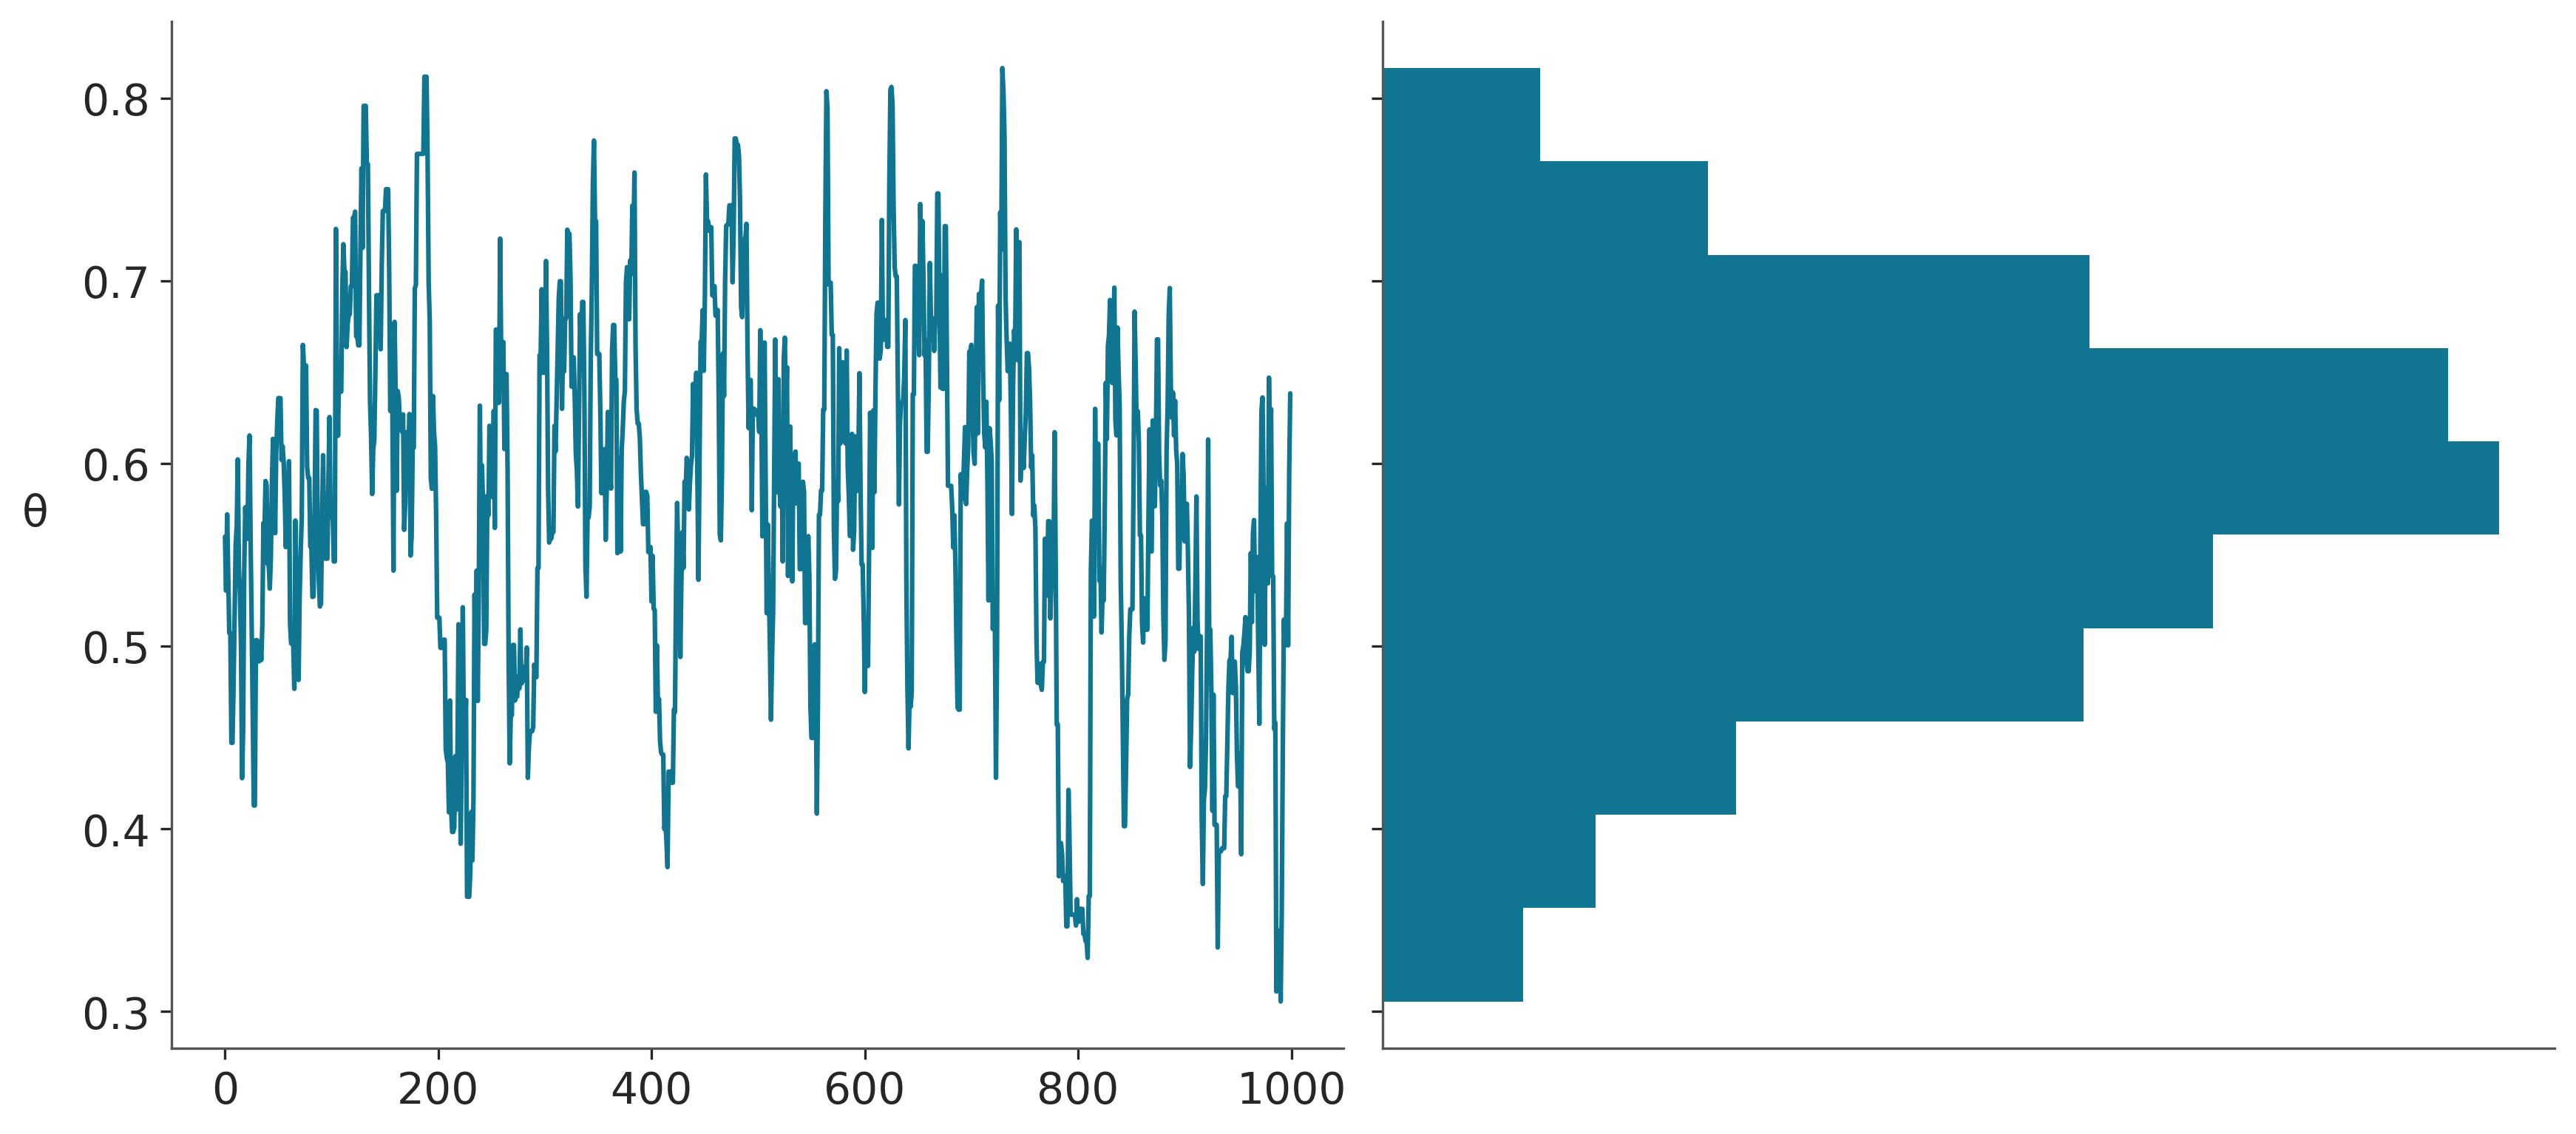

In [7]:
_, axes = plt.subplots(1,2, sharey=True)
axes[0].plot(trace['θ'])
axes[0].set_ylabel('θ', rotation=0, labelpad=15)
axes[1].hist(trace['θ'], orientation="horizontal", density=True)
axes[1].set_xticks([]);

### Metropolis-Hastings en detalle

Ahora veremos algunos detalles teóricos sobre el método. Esta sección puede ser omitida sin pérdida de dignidad.

La probabilidad de aceptación viene dada por:

$$
p_a (x_{i + 1} \mid x_i) = \min \left (1, \frac{p(x_{i + 1}) \; 
q(x_i \mid x_{i + 1})} {p(x_i) \; q (x_{i + 1} \mid x_i)} \right)
$$

Es decir, proponemos con probabilidad $q_{ij}$ (léase el subíndice $ij$ como
de $i$ a $j$) y se acepta la propuesta con probabilidad $a_{ij}$. Una de las ventajas de este método es que no necesitamos saber la constante de normalización de la distribución que queremos muestrear, ya que esa constante se cancela cuando calculamos $\frac{p_j}{p_i}$. Esto es muy importante porque en muchos problemas, incluida la inferencia Bayesiana, computar esa constante de normalización (la verosimilitud marginal) es muy
difícil.


Ahora probaremos que este método es correcto, es decir que la cadena generada por el método de Metropolis-Hastings es estacionaria con distribución $p$. Para probar ese es suficiente probar la condición de balance detallado.

Sea $\mathbf{T}$ la matriz de transición, solo necesitamos mostrar que $p_i t_{ij} = p_j t_{ji}$ para todos los $i$ y $j$, esto es trivial cuando $i = j$ por lo que asumimos que $i \neq j$, podemos escribir:


$$
t_{ij} = q_{ij} a_{ij} \tag{4.1}
$$

Lo que significa que la probabilidad de transición de $i$ a $j$ es la probabilidad de proponer el movimiento por la probabilidad de aceptarlo. Veamos primero el caso donde la probabilidad de aceptación es menor
que 1, esto pasa cuando $p_j q_{ji} \le p_i q_{ij}$, entonces tenemos que

$$
a_{ij} = \frac{p_j q_{ji}}{p_i q_{ij}} \tag{4.2}
$$

y también

$$
a_{ji} = 1
$$

Usando la ecuación $4.1$, tenemos

$$
p_i t_{ij} = p_i q_{ij} a_{ij}
$$


reemplazando $a_{ij}$ in la expresión $4.2$

$$
p_i t_{ij} = p_i q_{ij} \frac{p_j q_{ji}}{p_i q_{ij}}
$$


simplificando obtenemos:

$$
p_i t_{ij} = p_j q_{ji}
$$

Como $a_{ji} = 1$ podemos incluirlo sin cambiar la validez de la expresión

$$
p_i t_{ij} = p_j q_{ji} a_{ji}
$$

finalmente obtenemos

$$
p_i t_{ij} = p_j t_{ji}
$$


Por simetría cuando $p_j q_{ji} > p_i q_{ij}$ llegaremos al mismo resultado. Como se cumple la condición de reversibilidad, $p$ es la distribución estacionario de nuestra cadena de Markov con matriz de transición $\mathbf{T}$.

La prueba anterior nos da la confianza teórica de que podemos usar Metropolis-Hastings para muestrear de  prácticamente cualquier distribución que queramos. También podemos ver que este es un resultado muy general, y no probee de pistas sobre como elegir una distribución de propuesta.

En la práctica la distribución de propuesta es muy importante ya que la eficiencia del método depende fuertemente en esta elección. En general se observa que si la propuesta hace grandes saltos la probabilidad de aceptación es muy baja, y el método rechazará la mayoría de los nuevos estados. Por el contrario, si la propuesta da saltos demasiado pequeños, la la tasa de aceptación será alta pero la exploración del espacio de los parámetros sera muy pobre.


Entonces una buena distribución de propuesta será aquella que genera nuevos estados lejos del
antiguo estado con alta tasa de aceptación. Esto es generalmente difícil de hacer si no conocemos la geometría de la distribución posterior, que es precisamente lo que queremos averiguar. En la práctica lo métodos útiles tienen que ser adaptativos. Por ejemplo, podemos usar una distribución gaussiana multivariada como distribución de propuesta y realizar unos pasos de pruena o pasos de "ajust" (tuning), lo que usaremos para calcular la covarianza empírica de las muestras. Luego podemos utilizar esa covarianza para modificar la distribución de propuesta. Existe evidencia empírica y teórica indicando que la tasa de aceptación optima de los métodos de Metropolis-Hastings es de  0.4 para una dimensión y converge a 0.234 a medida que el número de parámetros se aproxima a infinito. También se sabe que en este caso "infinito" es basicamente menos de 10. Es decir aún si logramos obtener una buena distribución de propuesta recharazeremos más del 75% de los puntos propuestos.

En la siguiente sección discutiremos una forma inteligente de generar propuestas.

### Montecarlo Hamiltoniano (HMC)

Este es  un tipo de método MCMC que hace uso de gradientes para proponer nuevos estados. Los gradientes proporcionan información de la geometría del posterior. De esa forma, HMC intenta evitar el comportamiento de paseo aleatorio típico de Metropolis-Hastings utilizando el gradiente para proponer nuevas posiciones lejos
de la actual, pero con alta probabilidad de aceptación. Esto permite a HMC escalar mejor a dimensiones más altas y en principio más complejas.

En términos simples, un hamiltoniano es una descripción de la energía total de un sistema físico. Podemos descomponer la energía total en dos términos, el cinética y la energía potencial. Para un sistema real como una pelota que rueda cuesta abajo, la energía potencial viene dada por la posición de la pelota. Cuanto más alta se encuentre la pelota, mayor será la energía potencial. La energía cinética viene dada por la velocidad de la pelota, o más correctamente por su momemtum (que tiene en cuenta tanto la velocidad como la masa del objeto).
Supongamos que la energía total se conserva, lo que significa que si el sistema gana energía cinética entonces es porque ha perdido la misma cantidad de energía potencial. Podemos escribir el hamiltoniano de tales sistemas como:

$$
H(\mathbf{q}, \mathbf{p})  = K(\mathbf{p}, \mathbf{q}) + V(\mathbf{q})
$$

donde $K(\mathbf{p}, \mathbf{q})$ se llama energía cinética, y
$V(\mathbf{q})$ es la energía potencial. La probabilidad de encontrar la pelota en una posición particular con un impulso particular es:

$$
p(\mathbf{q}, \mathbf{p}) = e^{-H(\mathbf{q}, \mathbf{p})} \tag{4.3}
$$

Para simular estos sistemás necesitamos resolver las ecuaciones Hamiltonianas:


\begin{aligned}
\frac{d \mathbf{q}}{dt} =& \quad \frac{\partial H}{\partial \mathbf{p}} = \frac{\partial K}{\partial \mathbf{p}} + \frac{\partial V}{\partial \mathbf{p}} \\
\frac{d \mathbf{p}}{dt} =& -\frac{\partial H}{\partial \mathbf{q}}= -\frac{\partial K}{\partial \mathbf{q}} - \frac{\partial V}{\partial \mathbf{q}}
\end{aligned}

Tenga en cuenta que $\frac{\partial V}{\partial \mathbf{p}} = \mathbf{0}$.

Ya que no estamos interesados en modelar una pelota idealizada rodando hacia abajo de una colina idealizada, si no que queremos modelar una partícula idealizada a lo largo de la distribución posterior, necesitamos hacer algunos ajustes. Primero la energía potencial está dada por la densidad de probabilidad que estamos tratando de
muestrar, $p(\mathbf{q})$, es decir el posterior. Para el momemtum, vamos a invocar una variable auxiliar. Es decir, una variable inventada. Si elegimos $p(\mathbf{p} \mid \mathbf{q})$ entonces podemos escribir:

$$
p(\mathbf{q}, \mathbf{p}) = p(\mathbf{p} | \mathbf{q}) p(\mathbf{q}) \tag{4.4}
$$


Esto nos asegura que podemos recuperar nuestra distribución objetivo al marginalizar el momemtum. Al introducir la variable auxiliar, podemos continuar trabajando con la analogía física, y luego al eliminarla podemos volver al problema que realmente no interesa, obtener muestras del posterior.


Si reemplazamos 4.3 en 4.4 obtenemos:

$$
H(\mathbf{q}, \mathbf{p}) = \overbrace{-\log p(\mathbf{p} \mid \mathbf{q})}^{K(\mathbf{p}, \mathbf{ q})} \overbrace{- \log p(\mathbf{q})}^{ + V(\mathbf{q})}
$$

Como se explicó anteriormente, la energía potencial $V(\mathbf{q})$ está dada
por $p(\mathbf{q})$ la función de densidad de la distribución a posteriori y somos libres de elegir la energía cinética. Si elegimos una gaussiana y suprimimos la constante de normalización, tenemos:

$$
K(\mathbf{p}, \mathbf{q}) = \frac{1}{2}\mathbf{p}^T M^{-1}\mathbf{p} + \log |M|
$$

donde $M$ es la **matriz de precisión** que parametriza la distribución Gaussiana (también conocida como la matriz de masa). Y si elegimos $M = I$, es decir, la matriz identidad, una matriz cuadrara de $n \times n$ con unos en la diagonal principal y ceros en otros lugares, tenemos:

$$
K(\mathbf{p}, \mathbf{q}) = \frac{1}{2}\mathbf{p}^T \mathbf{p}
$$

Esto hace que los cálculos sean más fáciles como ahora.

$$
\frac{\partial K}{\mathbf{p}} = \mathbf{p}
$$

$$
\frac{\partial K}{\mathbf{q}} = \mathbf{0}
$$

Entonces podemos simplificar las ecuaciones Hamiltonianas:


\begin{align}
\frac{d \mathbf{q}}{dt} =& \mathbf{p} \\
\frac{d \mathbf{p}}{dt} =& - \frac{\partial V}{\partial \mathbf{q}}
\end{align}


Resumiendo, el algoritmo HMC es entonces:

1. Muestreamos $\mathbf{p} \sim \mathcal{N}(0, I)$

2. Simulamos $\mathbf{q}_t$ y $\mathbf{p}_t$ durante un período de tiempo
    $T$

3. $\mathbf{q}_T$ es nuestro nuevo estado propuesto

4. Utilizamos el criterio de aceptación de Metropolis para aceptar o rechazar
    $\mathbf{q}_T$.

¿Por qué todavía necesitamos usar el criterio de aceptación de Metropolis?
Intuitivamente  podemos pensar en HMC como un Metropolis-Hasting con una mejor distribución de propuestas. Pero también hay una muy buena justificación numérica, este paso corrige errores introducido por la simulación numérica de las ecuaciones Hamiltonianas.

Para calcular las ecuaciones hamiltonianas tenemos que calcular una trayectoria de la partícula, es decir, todos los puntos intermedios entre un estado y el siguiente. En la práctica, esto implica calcular una serie de pequeños pasos de *integración* usando un método integrador. El más popular es se llama leap-frog. La integración de Leapfrog es equivalente a actualizar la posición y el momento impulso de forma intercalada.


El siguiente bloque de código muestra el integrador leap-frog. Los argumentos son: `q` y `p`, la posición inicial y el momento respectivamente. `dVdq` es una función de Python que devuelve el gradiente $\frac{\partial V}{\\mathbf{q}}$ . Usamos JAX para generar esta función. `path_len` indica cuánto tiempo se integrará y `step_size` qué tamaño tiene cada uno de los pasos de integración. Como resultado obtenemos una nueva posición y
momento.

In [8]:
def leapfrog(q, p, dVdq, path_len, step_size):
    p -= step_size * dVdq(q) / 2  # half step
    for _ in range(int(path_len / step_size) - 1):
        q += step_size * p  # whole step
        p -= step_size * dVdq(q)  # whole step
    q += step_size * p  # whole step
    p -= step_size * dVdq(q) / 2  # half step

    return q, -p  # momentum flip at end

SyntaxError: invalid syntax (657178628.py, line 10)

En la función `leapfrog` cambiamos el signo del momemtum. Esta es una forma sencilla de lograr una propuesta reversible.

Ahora tenemos todos los ingredientes para implementar un método HMC en Python. Esta implementación es pedagógica y no tiene como objetivo ser utilizada para problemas reales. Los argumentos son `n_samples` el
número de muestras a devolver, `negative_log_prob` el logaritmo negativo de la probabilidad a mujestrear, `initial_position` la posición inicial.

In [ ]:
def hamiltonian_monte_carlo(
    n_samples, negative_log_prob, initial_position, 
    path_len, step_size):
    # autograd magic
    dVdq = jax.grad(negative_log_prob)

    # collect all our samples in a list
    samples = [initial_position]

    # Keep a single object for momentum resampling
    momentum = stats.norm(0, 1)
    # If initial_position is a 10d vector and n_samples is 100, we want
    # 100 x 10 momentum draws. We can do this in one call to momentum.rvs, and
    # iterate over rows
    size = (n_samples,) + initial_position.shape[:1]
    for p0 in momentum.rvs(size=size):
        # Integrate over our path to get a new position and momentum
        q_new, p_new = leapfrog(
            samples[-1], p0, dVdq, path_len=path_len, step_size=step_size,
        )

        # Check Metropolis acceptance criterion
        start_log_p = negative_log_prob(samples[-1]) - np.sum(momentum.logpdf(p0))
        new_log_p = negative_log_prob(q_new) - np.sum(momentum.logpdf(p_new))
        if np.log(np.random.rand()) < start_log_p - new_log_p:
            samples.append(q_new)
        else:
            samples.append(np.copy(samples[-1]))

    return np.array(samples[1:])

La siguiente figura muestra 3 trayectorias diferentes alrededor de la misma distribución normal 2D. El momento
se indica por el tamaño y la dirección de las flechas, con flechas pequeñas indicando una valor pequeño de la energía cinética. Todas estas trayectorias se calculan de tal manera que terminan en su posición inicial

En la práctica no queremos que las trayectorias sean circulares, por que eso implica llegar a la misma
posición en la que empezamos. En cambio, lo que queremos es movernos lo más lejos posible de nuestro punto de partida. Una variante de HMC que evita estás vueltas en U es NUTS, el método por defecto en PyMC. Cuya sigla es No-U-Turn Sampler.

In [ ]:
figures/normal_leapfrog.png

La siguiente figura muestra 3 trayectorias diferentes alrededor del mismo embudo de Neal, una geometría común
en modelos jerárquicos. Estos son ejemplos de trayectorias que no logra seguir el camino correcta. Tales trayectorias se llaman trayectorias divergentes, o simplemente divergencias. Es posible utilizar estas divergecias como diagnósticos, es decir si obtenemos divergencias quiere decir que el muestreo puede no ser confiable.

In [ ]:
figures/funnel_leapfrog.png

Las dos figuras anteriores resaltan el hecho de que un HMC eficiente requiere de un ajuste adecuado de sus hiperparámetros. HMC tiene tres hiparámetros:

- la discretización del tiempo (tamaño de paso del salto)

- el tiempo de integración (número de pasos de salto)

- la matriz de precisión $M$ que parametriza la energía cinética

Si el tamaño del paso es demasiado grande, el integrador será inexacto y se rechazarán demasiadas propuestas. Sin embargo, si es demasiado pequeño desperdiciaremos recursos de cómputo. Si el número de pasos es demasiado pequeño, la trayectoria simulada en cada iteración será demasiado corta y el muestreo se comportará de forma similar a una caminata aleatoria. Pero si es demasiado grande, la trayectoria podría correr en círculos y nuevamente desperdiciaremos recursos. Si la covarianza estimada (inversa de la matriz de precisión)
es demasiado diferente de la covarianza del posterior, el momemtum será subóptimo y el movimiento de la partícula será demasiado grande o demasiado pequeño en alguna dimensión.

Métodos de Monte Carlo Hamiltonianos dinámicos y adaptativos, como el utilizado por PyMC y otros PPL pueden adaptar estos hiperparámetros automáticamente durante la fase de calentamiento o ajuste. El tamaño del paso puede ser aprendiendo automáticamente ajustándolo para que coincida con un valor predefinido de la tasa de aceptación. En PyMC este valor predefinido se puede modificar con el argumento `target_accept`, por defecto es 0.8, pero a veces puede ser necesario aumentarlo. La matriz de precisión $M$ o su inversa puede ser estimada a partir de las muestras durante la fase de calentamiento/tuning y el número de pasos se puede adaptar dinámicamente en cada paso. Para evitar una trayectoria demasiado larga que podría pasar cerca
el punto de inicialización, NUTS extiende la trayectoria hacia atrás y hacia adelante hasta que se cumpla un criterio de giro en U. Además, NUTS aplica un muestreo multinomial para elegir entre todos los puntos generados de la trayectoria, ya que esto proporciona un mejor criterio para una exploración eficiente de la distribución objetivo que simplemente el final de la trayectoria.

### Montecarlo secuencial

Sequential Monte Carlo es una familia de métodos de Monte Carlo también conocida como filtros de partículas. Hay muchos variaciones e implementación bajo el mismo nombre. Por lo que la literatura sobre el temas suele ser bastante confusa. Daremos una breve descripción del método SMC/SMC-ABC implementado en PyMC y TFP. Para una discusión detallada de los métodos SMC bajo un marco unificado recomendamos el libro [An Introduction to
Montecarlo secuencial](https://link.springer.com/book/10.1007/978-3-030-47845-2).

Primero tenga en cuenta que podemos escribir el posterior de la siguiente manera:

$$
p(\boldsymbol{\theta} \mid Y)_{\beta} \propto
    p(Y \mid \boldsymbol{\theta})^{\beta} \; p(\boldsymbol{\theta})
$$

Cuando $\beta = 0$ vemos que $p(\boldsymbol{\theta} \mid Y)_{\beta}$ es el prior y cuando $\beta = 1$ vemos que
$p(\boldsymbol{\theta} \mid Y)_{\beta}$ es el *verdadero* posterior.


SMC procede aumentando el valor de $\beta$ en $s$ etapas sucesivas $\{\beta_0=0 < \beta_1 < ... < \beta_s=1\}$. ¿Por qué es una buena idea? Hay dos formas relacionadas de justificarlo. En lugar de tratar directamente de tomar muestras del posterior, comenzamos muestreando desde el prior, que generalmente es una tarea más sencilla. Después vamos añadiendo distribuciones intermedias hasta llegar al posterior, de forma tal que pasar de una a otra sea siemple una tarea realtivamente simple. La segunda es una analogía con la temperatura. Los parámetros $\beta$ son análogos a la temperatura inversa de un sistema físico, a medida que disminuimos su valor (aumentamos la temperatura) el sistema es capaz de acceder a más estados, y a medida que aumentamos su valor (disminuimos la temperatura) el sistema se "congela" en la disribución a posteriori. 

En la siguiente figura se muestra una secuencia hipotética de posteriores templados. 


El método SMC, implementado en PyMC y TFP, se puede resumir como
sigue:

1. Inicialice $\beta$ en cero.

2. Genere $N$ muestras $s_{\beta}$ del posterior templado.

3. Aumente $\beta$ para mantener el tamaño efectivo de la muestra en un valor predefinido.

4. Calcule un conjunto de pesos de importancia $N$ $W$. los pesos son calculado de acuerdo con al posterior templado nuevo y antiguo.

5. Obtenga $s_w$ remuestreando $s_{\beta}$ según $W$.

6. Ejecute $N$ cadenas MCMC para $k$ pasos, comenzando cada uno desde un muestra diferente en $s_w$ y conservando solo las muestras en el último paso.

7. Repita desde el paso 3 hasta $\beta=1$

El paso de remuestreo funciona eliminando muestras con baja probabilidad y reemplazándolos con muestras con una mayor probabilidad. Este paso disminuye la diversidad de las muestras. Entonces, el paso MCMC perturba las
muestras, con la esperanza de aumentar la diversidad y, por lo tanto, ayudar a SMC a explorar el espacio de parámetros. 

La eficiencia del método temperado depende en gran medida de la valores intermedios de $\beta$. Cuanto menor sea la diferencia entre dos valores sucesivos de $\beta$, más cercas serán las distribuciones a posteriori templadas y por lo tanto más fácil será la transición de una etapa a la siguiente. Pero si los pasos son demasiado pequeños, necesitaremos muchas estapas intermedias y estaremos desperdiciando una gran cantidad de recursos computacionales sin mejorar realmente la precisión de los resultados. Otro factor importante es la eficiencia del método de MCMC utilizado. Para ayudar a mejorar la eficiencia de la transición, se pueden emplear las muestras de la etapa anterior para ajustar la distribución de propuesta y otro hiperparámetros. En cierto sentido todos los pasos, excepto $\beta=1$ pueden considerarse como pasos de tuning cuya función es lograr que el muestro durante el estado $\beta=1$ sea eficiente.

## Para seguir leyendo

[Exploratory Analysis of Bayesian Models](https://github.com/arviz-devs/Exploratory-Analysis-of-Bayesian-Models/tree/main/content) Trabajo en Progreso!

[A Conceptual Introduction to Hamiltonian Monte Carlo](https://arxiv.org/abs/1701.02434)

[Rank-normalization, folding, and localization](https://arxiv.org/abs/1903.08008)

[Computing Bayes: Bayesian Computation from 1763 to the 21st Century](https://arxiv.org/abs/2004.06425).